The situation here is a gas in a trap whos density follows a gaussian as a function of distance from the trap center. Since we are taking images, and the image plane is assumed to be in the center of the trap, it falls off in the plane of the image like a 2d gaussian. I am assuming, to simplify things, that the laser uniformly illuminates all atoms. This is reasonable because I am saying the trap is on the order of 10's of micrometers, and with a laser of a width of about 1 mm the atoms all experience nearly the same intensity almost no matter what the laser looks like (assuming it isn't some insane shape). The collected data is a series of 2d images. In this notebook I will be creating the data to analyze. The final goal of the analysis will be to determine the temperature of the trapped atoms. 

See the analysis notebook for more info on the physics

In [1]:
import scipy.special as sps 
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits

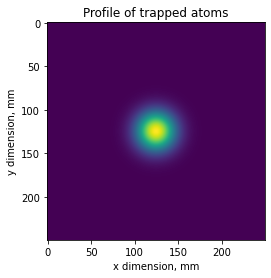

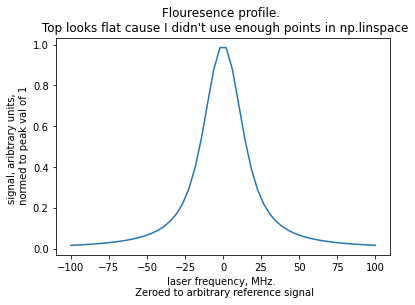

In [8]:
def gauss(x,y,a,sigma=5,x0=0,y0=0,b=0):
    #This function returns the image signal as a function of distance from trap center. Notice there is no
    #frequency dependence so the output must be multiplied by a frequency dependence to simulate laser scanning
    #x: position in x direction, um
    #y: position in y direction, um
    #a: height of gaussian, atoms/um**3. 
    #sigma: sigma of gaussian profile, um. By default this is 5 unless overwridden
    #x0: center of gaussian in x direction, um. By default 0
    #y0: center of gaussian in y direction, um. By default 0
    #b: There could be some background gas of lithium atoms that also fluoresces, but does so evenly in space.
    gaussx=np.exp(-(x-x0)**2/(2*sigma*2))
    gaussy=np.exp(-(y-y0)**2/(2*sigma*2))
    return a*gaussx*gaussy+b
def voigt(v,sigma,gamma,v0=0):
    #A Voigt profile describes the flourescence profile as a function of frequency for many system. See above for
    #more description. The voigt profile is defined such that the total area is 1, but we want the peak to be 1
    #so we need to do a little trick
    #v: frequency of laser, MHz.
    #sigma: sigma from a gaussian profile. Not the same sigma as the function above, this is sigma in 
        #frequency, not space. They are not related. The sigma above in space is a functiong of the trap
    #gamma: Half Width Half Max (HWHM) of a lorentzian profile, MHz.
    #v0: frequency of lithium transition we are probing, MHz
    v0Peak= sps.voigt_profile(0,sigma,gamma)
    return sps.voigt_profile((v-v0),sigma,gamma)/v0Peak


#let's see what these look like
#first see for gauss.
numPoints=250
xArr=np.linspace(-25,25,num=numPoints)
yArr=np.linspace(-25,25,num=numPoints)
inputGrid=np.meshgrid(xArr,yArr) #this creates a list of length two where each entry is an array of dimension 
        #(numPoints x numPoints), ie a matrix. The first entry represents the x coordinates, the second the y coordinates.
        #Physically this is a 250 pixel by 250 pixel image

    
#print(inputGrid)  #you can print it if you want to see what it looks like. Decrease numPoints so it's easier
        #to see

#Now let's use this grid to construct our gaussian profile in 2d that represents the density of atoms in the
#transverse imaging plane.
a0=1E3 #atoms/um**3
spatialProfile=gauss(inputGrid[0],inputGrid[1],a0)
plt.imshow(spatialProfile)
plt.title("Profile of trapped atoms")
plt.xlabel("x dimension, mm")
plt.ylabel("y dimension, mm")
plt.show()

#Now let's plot the flourescense as a function of frequency. This will affect all atoms.
vArr=np.linspace(-100,100) #since I don't provide num=something, numpy will use its default value of 50 points       
vProfile=voigt(vArr,5.89,12)
plt.plot(vArr,vProfile)
plt.title("Flouresence profile. \n Top looks flat cause I didn't use enough points in np.linspace")
plt.ylabel("signal, aribtrary units, \n normed to peak val of 1")
plt.xlabel("laser frequency, MHz. \n Zeroed to arbitrary reference signal")
plt.show() 


#so that all looks good, but REAL data is noisey. It's also not always nice and centered. In the next cell I make
#noisey uncentered data to analyze

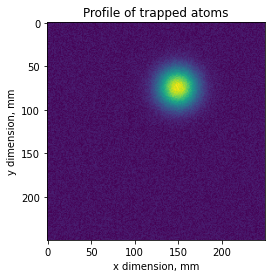

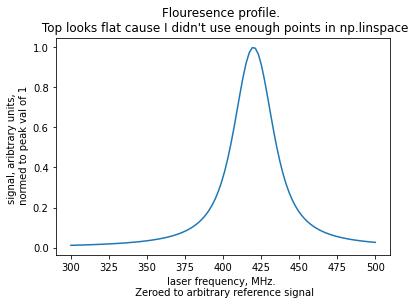

THAT FILE ALREADY EXISTS. DELETE IT TO OVERWRITE@


In [5]:
a0=1E3
x0=5 #let's offset it
y0=-10
spatialProfile=gauss(inputGrid[0],inputGrid[1],a0,x0=x0,y0=y0)
#now let's make it noise. To do this, make a random 3d array of the same exact shape as spatial profile
randomProfile=np.random.random_sample(spatialProfile.shape) #you could use np.random.rand, but then you would need
#to 'unpack' spatialProfile.shape. It would look like np.random.rand(*spatialProfile.shape). This function is left
#over from the old days of numpy but people still use it for backwards compatibility. 
#Numpy is over 30 years so it has some baggage. spatialProfile.shape is a 'tuple'


#Let's scale random profile correctly
randomProfile=randomProfile*a0/10 #the noise is 10 times less than than peak signal, a SNR (Signal to Noise Ratio)
    #of 10
#now combine them
spatialProfile=spatialProfile+randomProfile


plt.imshow(spatialProfile)
plt.title("Profile of trapped atoms")
plt.xlabel("x dimension, mm")
plt.ylabel("y dimension, mm")
plt.show()
#HEY! what gives, we said -10 for y0, not a positive value, why is it higher than the center? Because
#numpy coordinates start at the top left for arrays, not the bottom left! DONT FORGET THAT! FITs software
#a common standard for image analysis in astro, uses the bottom left though.



#Now let's make the flourescene signal again.
vArr=np.linspace(300,500,num=100) #100 pictures this time       
v0=420

vProfile=voigt(vArr,5.9,12,v0=v0)

plt.plot(vArr,vProfile)
plt.title("Flouresence profile. \n Top looks flat cause I didn't use enough points in np.linspace")
plt.ylabel("signal, aribtrary units, \n normed to peak val of 1")
plt.xlabel("laser frequency, MHz. \n Zeroed to arbitrary reference signal")
plt.show() 

#Now we have some nice real data. Let's now make a list of images that we could collect


imageList=[]
spatialProfile0=gauss(inputGrid[0],inputGrid[1],a0,x0=x0,y0=y0) #so I don't have to keep remaking this
for signal in vProfile:
    spatialProfile=spatialProfile0*signal
    
    offset=1E3 #all cameras have offset because a negative value of photons is nonsensical
    
    spatialProfile+=offset #I'm using the plus-equal operator. This is the same as
            #spatialProfile=spatialProfile+offset. 
    
    #make the noise
    randomProfile=np.random.random_sample(spatialProfile0.shape)
    randomProfile=randomProfile*a0/10 #new noise for each image. Obviously this is what actually happens.
    

    spatialProfile=spatialProfile+randomProfile    #then we add noise
    
    imageList.append(spatialProfile)#append the image


#now let's use the common standard of FITs file to save out images. Astronomy is at the cutting edge of
#image aquisition and is very technical. As such, saving fits files isn't totally obvious, and is itself
#a little technical. 
hdu=fits.PrimaryHDU(imageList) #make a Header/Data Unit of images
hdul=fits.HDUList([hdu]) #list of HDUs to save
try:
    hdul.writeto("data.fits") #now save it
except: #fits doesn't let you delete stuff accidently
    print('THAT FILE ALREADY EXISTS. DELETE IT TO OVERWRITE@')

#if you want to look at the results, download SAOImage ds9. It's a little trick to use, but very powerful and
#very common



#Now save the frequency axis, we will need that later
np.savetxt('FrequencyData',vArr)

(100, 250, 250)


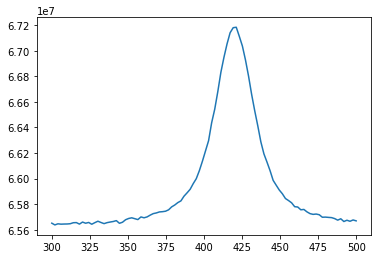

In [4]:
#Now let's open the saved data and plot the sum of each frame and see what it looks like. Again, a little technical
fitsFile=fits.open('data.fits')
imagesList=fitsFile[0].data

#Let's convert imagesList to a numpy array so we can use the nice numpy functions to sum each image
imagesArr=np.asarray(imagesList)
print(imagesArr.shape) #verify the shape makes sense. We have a 250x250 image taken 100 times
#Sum each image to make an array of length 100 where each entry is the sum of all the pixel values
#in that image. Numpy axis ordering is z,y,x

imagesSumArr=np.sum(imagesArr,axis=2) #first sum along x axis. [z,y,x] so axis=2 says sum along x. The new
    #array has the x component gone!
imagesSumArr=np.sum(imagesSumArr,axis=1) #now sum along y axis. [z,y] so axis=1 says sum along y


#Open the frequency data and plot the images on the frequency
vArr=np.loadtxt('FrequencyData')

plt.plot(vArr,imagesSumArr)
plt.show()
#look good!!!